# Yelp Data - Causality Analysis

## RDS 데이터베이스 준비

먼저 RDS 데이터베이스에 접속한뒤 다음을 실행

```sql
CREATE DATABASE yelp;

GRANT SELECT, INSERT, UPDATE, DELETE, CREATE, DROP, RELOAD, PROCESS, REFERENCES, INDEX, ALTER, SHOW DATABASES, CREATE TEMPORARY TABLES, LOCK TABLES, EXECUTE, REPLICATION SLAVE, BINLOG MONITOR, CREATE VIEW, SHOW VIEW, CREATE ROUTINE, ALTER ROUTINE, CREATE USER, EVENT, TRIGGER, DELETE HISTORY, SLAVE MONITOR ON *.* TO `anderson`@`%` IDENTIFIED BY '1234567890' WITH GRANT OPTION;

```

Java 8 설치

```bash
$ sudo apt-get install openjdk-8-jdk
$ sudo update-alternatives --config java
```

In [52]:
# Dependencies
!pip install -q pymysql h3 

# EMBULK
!embulk gem install embulk-input-mysql embulk-output-mysql

%pylab inline

import numpy as np
import pandas as pd
import pandas_profiling
import json
import pymysql
import pickle
import seaborn as sns
import csv
import re
import os
import shutil

from pathlib import Path
from keplergl import KeplerGl 
from h3 import h3
from tqdm.notebook import tqdm_notebook as tqdm

2022-11-11 23:48:05.483 +0900: Embulk v0.9.24

Gem plugin path is: /home/anderson/.embulk/lib/gems

2 gems installed
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data

## Business

In [2]:
conn = pymysql.connect(host='localhost', 
                       user='anderson', 
                       password='1234567890',
                       db='yelp', charset='utf8')

In [3]:
import pandas as pd
import kaggle.api as kaggle
from tempfile import gettempdir
from pathlib import Path

data_dir = Path(gettempdir()) / 'yelp-dataset'
if not data_dir.exists():
    kaggle.authenticate()
    kaggle.dataset_download_files('yelp-dataset/yelp-dataset',
                                  data_dir, 
                                  unzip=True)

In [3]:
bs_data = pd.read_json('/tmp/yelp-dataset/yelp_academic_dataset_business.json',
                       lines=True)

# H3
bs_data['h3'] = bs_data[['latitude', 'longitude']].apply(
    lambda x: h3.geo_to_h3(x['latitude'], x['longitude'], 7), axis=1)

# Rank & Drop columns
bs_data['rank'] = bs_data['stars'] * bs_data['review_count']
bs_data.drop(['address', 'postal_code', 'hours', 'attributes'], axis=1, inplace=True)

# Category
bs_data['categories'] = bs_data['categories'].str.lower()
bs_data['categories'].fillna('', inplace=True)


## Business visualization

In [4]:
bs_data = bs_data.reset_index().drop('index', axis=1)
bs_data.to_csv('/tmp/yelp-dataset/business.csv', index=False)
print('shape:', bs_data.shape)
display(bs_data.head())

shape: (150346, 12)


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,categories,h3,rank
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara,CA,34.426679,-119.711197,5.0,7,0,"doctors, traditional chinese medicine, naturop...",872912649ffffff,35.0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,1,"shipping centers, local services, notaries, ma...",87264624effffff,45.0
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson,AZ,32.223236,-110.880452,3.5,22,0,"department stores, shopping, fashion, home & g...",8748e8554ffffff,77.0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,"restaurants, food, bubble tea, coffee & tea, b...",872a134d4ffffff,320.0
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane,PA,40.338183,-75.471659,4.5,13,1,"brewpubs, breweries, food",872aac932ffffff,58.5


## Business Map Visualization

In [5]:
# Kepler
bs_m = KeplerGl(height=500)
bs_m.add_data(bs_data)
bs_m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [8]:
pickle.dump(bs_m.get_state(), open('states/business_map.pickle', 'wb'))
bs_m.save_to_html(file_name='business.html')
!google-chrome business.html

Map saved to business.html!
Opening in existing browser session.


In [11]:
!embulk guess seed_business.yml -o config_business.yml -l error
!embulk run config_business.yml -l error

2022-11-11 22:29:46.437 +0900: Embulk v0.9.24
2022-11-11 22:29:46.940 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2022-11-11 22:29:48.403 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2022-11-11 22:29:48.849 +0900 [INFO] (main): Started Embulk v0.9.24
2022-11-11 22:29:48.918 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'business.csv'
2022-11-11 22:29:48.918 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2022-11-11 22:29:48.919 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/business.csv]
2022-11-11 22:29:48.927 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2022-11-11 22:29:48.967 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.24)
2022-11-11 22:29:48.980 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.24)
2022-11-11 22:

In [13]:
conn = pymysql.connect(host='localhost', 
                       user='anderson',
                       password='1234567890',
                       db='yelp', 
                       charset='utf8')
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_business_on_business_id on business (business_id(40));')
    cursor.execute('create index if not exists idx_business_on_state on business (state(5));')
    cursor.execute('create index if not exists idx_business_on_h3 on business (h3(20));')
cursor.fetchall()

()

### 카테고리 

In [15]:
from collections import Counter

category_df = bs_data['categories'].str.split(',')

counter = {}
for row in category_df:
    if row is None:
        continue
    for category in row:
        category = category.strip().lower()
        counter.setdefault(category, 0)
        counter[category] += 1
counter = Counter(counter)
counter.most_common(10)

[('restaurants', 52268),
 ('food', 27781),
 ('shopping', 24395),
 ('home services', 14356),
 ('beauty & spas', 14292),
 ('nightlife', 12281),
 ('health & medical', 11890),
 ('local services', 11198),
 ('bars', 11065),
 ('automotive', 10773)]

### star distribution

In [22]:
star_count

,business_id
stars,
1.0,1986
1.5,4932
2.0,9527
2.5,14316
3.0,18453
3.5,26519
4.0,31125
4.5,27181
5.0,16307


<AxesSubplot:xlabel='stars_int', ylabel='business_id'>

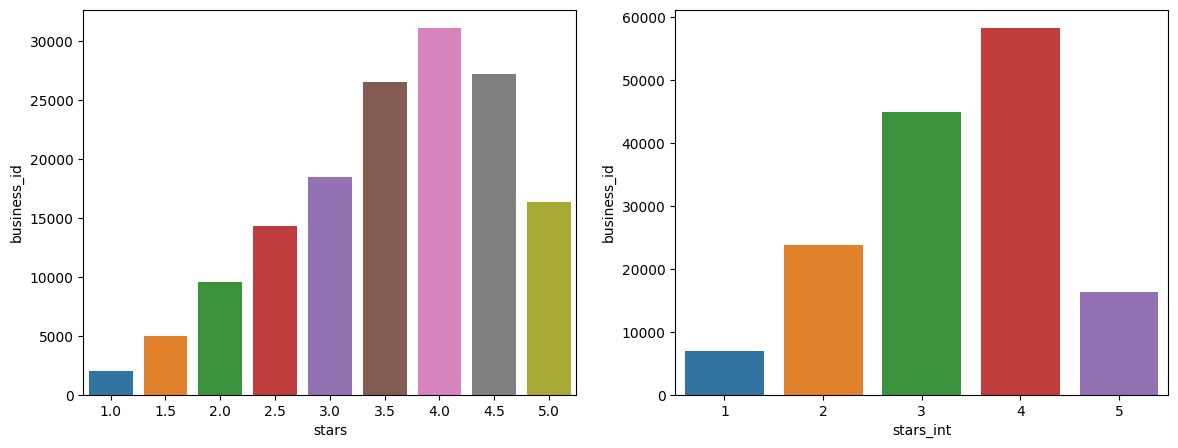

In [24]:
fig, plots = subplots(1, 2, figsize=(14, 5))

star_count = bs_data[['stars', 'business_id']].groupby('stars').count()
sns.barplot(x=star_count.index, y='business_id', data=star_count, ax=plots[0])

bs_data['stars_int'] = bs_data['stars'].astype('int')
star_count = bs_data[['stars_int', 'business_id']].groupby('stars_int').count()
sns.barplot(x=star_count.index, y=star_count.business_id, data=star_count, ax=plots[1])

## Checking Data

In [61]:
def create_checking_data(
    input_file='/tmp/yelp-dataset/yelp_academic_dataset_checkin.json',
    output_dir='./yelp-dataset/checkin', 
    force=False, max_iter=70):
    """
    연산에 너무 오래 걸리고, 구글 코랩에서는 돌아가지 않음. 
    yelp-dataset/checkin.csv 파일이 완료된 파일이니 이거 사용
    """
    output_dir = Path(output_dir)
    if output_dir.exists():
        if force:
            shutil.rmtree(output_dir)
        else:
            print('checking data has been already created')
            return
    
    if not output_dir.exists():
        os.mkdir(output_dir)
    
    
    ck_chunk = pd.read_json(input_file, lines=True, chunksize=2000)
    business_ids = set(bs_data['business_id'].unique())
    
    for i, ck_data in tqdm(enumerate(ck_chunk), total=max_iter):
        if i >= max_iter:
            print('Reached Max Iteration. Break!')
            break

        ck_data = ck_data[ck_data['business_id'].isin(business_ids)]
        ck_data.set_index('business_id', inplace=True)

        # Preprocessing
        def convert_datetimes(x):
            x = pd.to_datetime(x)
            return x

        dts_df = ck_data['date'].str.split(',').apply(convert_datetimes)
        dts_df = pd.DataFrame(dts_df.tolist(), index=dts_df.index).stack().reset_index()
        dts_df.drop('level_1', axis=1, inplace=True)
        dts_df.rename({0: 'checkin'}, axis=1, inplace=True)
        # dts_df['year'] = dts_df['checkin'].dt.year
        # dts_df['month'] = dts_df['checkin'].dt.month
        # dts_df['hour'] = dts_df['checkin'].dt.hour

        dts_df.to_parquet(output_dir / f'checkin{i:02}.parquet', index=False)

# create_checking_data(max_iter=70, force=True)
dts_df = pd.read_parquet('./yelp-dataset/checkin')
dts_df.head(5)

,business_id,checkin
0,---kPU91CF4Lq2-WlRu9Lw,2020-03-13 21:10:56
1,---kPU91CF4Lq2-WlRu9Lw,2020-06-02 22:18:06
2,---kPU91CF4Lq2-WlRu9Lw,2020-07-24 22:42:27
3,---kPU91CF4Lq2-WlRu9Lw,2020-10-24 21:36:13
4,---kPU91CF4Lq2-WlRu9Lw,2020-12-09 21:23:33


In [34]:
!embulk guess seed_checkin.yml -o config_checkin.yml -l error
!embulk run config_checkin.yml -l error

2022-11-11 23:04:13.252 +0900: Embulk v0.9.24
in:
  type: file
  path_prefix: ./yelp-dataset/checkin.csv
  parser:
    type: csv
    charset: UTF-8
    newline: LF
    delimiter: ','
    quote: '"'
    escape: '"'
    trim_if_not_quoted: false
    skip_header_lines: 1
    allow_extra_columns: false
    allow_optional_columns: false
    columns:
    - {name: business_id, type: string}
    - {name: checkin, type: timestamp, format: '%Y-%m-%d %H:%M:%S'}
    - {name: year, type: long}
    - {name: month, type: long}
    - {name: hour, type: long}
out: {type: mysql, host: localhost, user: anderson, password: '1234567890', database: yelp,
  table: checkin, mode: replace}

Created 'config_checkin.yml' file.
2022-11-11 23:04:18.010 +0900: Embulk v0.9.24


In [40]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_checkin_on_business_id on checkin (business_id(40));')
    cursor.execute('create index if not exists idx_checkin_on_year on checkin (year);')
    cursor.execute('create index if not exists idx_checkin_on_month on checkin (month);')
    
cursor.fetchall()

()

<AxesSubplot:xlabel='hour', ylabel='checkin'>

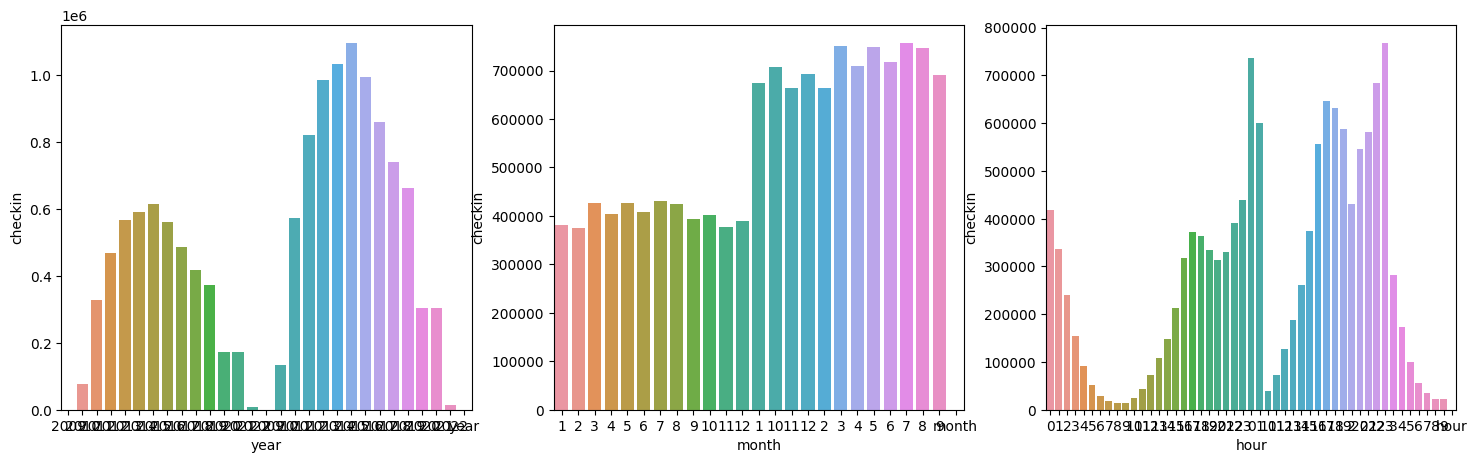

In [42]:
fig, plots = subplots(1, 3, figsize=(18, 5))
plots = plots.reshape(-1)

year_df = dts_df.groupby('year')['checkin'].count()
month_df = dts_df.groupby('month')['checkin'].count()
hour_df = dts_df.groupby('hour')['checkin'].count()

sns.barplot(x=year_df.index, y=year_df, ax=plots[0])
sns.barplot(x=month_df.index, y=month_df, ax=plots[1])
sns.barplot(x=hour_df.index, y=hour_df, ax=plots[2])


## Review

In [44]:
!embulk guess seed_review.yml -o config_review.yml -l error
!embulk run config_review.yml -l error

2022-11-11 23:25:44.092 +0900: Embulk v0.9.24
in:
  type: file
  path_prefix: /tmp/yelp-dataset/yelp_academic_dataset_review.json
  parser:
    type: json
    columns:
    - {name: review_id, type: string}
    - {name: user_id, type: string}
    - {name: business_id, type: string}
    - {name: stars, type: double}
    - {name: useful, type: double}
    - {name: funny, type: double}
    - {name: cool, type: double}
    - {name: text, type: string}
    - {name: date, type: timestamp, format: '%Y-%m-%d %H:%M:%S'}
    charset: UTF-8
    newline: LF
out: {type: mysql, host: localhost, user: anderson, password: '1234567890', database: yelp,
  table: review, mode: replace}

Created 'config_review.yml' file.
2022-11-11 23:25:47.272 +0900: Embulk v0.9.24


In [16]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_review_on_user_id on review (user_id(40));')
    cursor.execute('create index if not exists idx_review_on_business_id on review (business_id(40));')
    cursor.execute('create index if not exists idx_review_on_date on review (date);')
    
cursor.fetchall()

()

## Tip Data


In [17]:
!embulk guess seed_tip.yml -o config_tip.yml
!embulk run config_tip.yml

2019-11-13 18:37:53.873 +0900: Embulk v0.9.19
2019-11-13 18:37:54.168 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-13 18:37:55.359 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-13 18:37:55.735 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-13 18:37:55.768 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_tip.json'
2019-11-13 18:37:55.769 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-13 18:37:55.769 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_tip.json]
2019-11-13 18:37:55.774 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-13 18:37:55.835 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-13 18:37:55.847 +0900 [INFO] (0001:guess): Loaded p

In [18]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_tip_on_user_id on tip (user_id(40));')
    cursor.execute('create index if not exists idx_tip_on_business_id on tip (business_id(40));')
    cursor.execute('create index if not exists idx_tip_on_date on tip (date);')
    
cursor.fetchall()

()

## User

In [19]:
!embulk guess seed_user.yml -o config_user.yml
!embulk run config_user.yml

2019-11-13 18:38:41.885 +0900: Embulk v0.9.19
2019-11-13 18:38:42.174 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-13 18:38:43.393 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-13 18:38:43.803 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-13 18:38:43.839 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_user.json'
2019-11-13 18:38:43.839 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-13 18:38:43.840 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_user.json]
2019-11-13 18:38:43.846 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-13 18:38:43.903 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-13 18:38:43.914 +0900 [INFO] (0001:guess): Loaded

In [20]:
with conn.cursor() as cursor:
    cursor.execute('create index idx_user_on_user_id on user (user_id(40));')
    
cursor.fetchall()

()

## Friends

In [24]:
f = open('yelp-dataset/yelp_academic_dataset_user.json', 'rt')
with open('yelp-dataset/friends.csv', 'wt') as wf:
    writer = csv.writer(wf)
    
    writer.writerow(['user_id', 'friend_id'])
    for line in tqdm(f):
        line = json.loads(line)
        user_id = line['user_id']
        friends = line['friends'].split(',')
        friends = [(user_id, f) for f in friends]
        writer.writerows(friends)
f.flush()
f.close()

In [25]:
!embulk guess seed_friends.yml -o config_friends.yml
!embulk run config_friends.yml

2019-11-14 16:17:02.001 +0900: Embulk v0.9.19
2019-11-14 16:17:02.289 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-11-14 16:17:03.587 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-11-14 16:17:03.981 +0900 [INFO] (main): Started Embulk v0.9.19
2019-11-14 16:17:04.016 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'friends.csv'
2019-11-14 16:17:04.016 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-11-14 16:17:04.017 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/friends.csv]
2019-11-14 16:17:04.023 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-11-14 16:17:04.080 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 16:17:04.090 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-11-14 16:17

In [ ]:
with conn.cursor() as cursor:
    cursor.execute('create index idx_user_id_on_friends on friends (user_id(40));')
    cursor.execute('create index idx_friend_id_on_friends on friends (friend_id(40));')
    
cursor.fetchall()